The Project
---

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

The images for camera calibration are stored in the folder called `camera_cal`.  The images in `test_images` are for testing your pipeline on single frames.  If you want to extract more test images from the videos, you can simply use an image writing method like `cv2.imwrite()`, i.e., you can read the video in frame by frame as usual, and for frames you want to save for later you can write to an image file.  

To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called `output_images`, and include a description in your writeup for the project of what each image shows.    The video called `project_video.mp4` is the video your pipeline should work well on.  

The `challenge_video.mp4` video is an extra (and optional) challenge for you if you want to test your pipeline under somewhat trickier conditions.  The `harder_challenge.mp4` video is another optional challenge and is brutal!

If you're feeling ambitious (again, totally optional though), don't stop there!  We encourage you to go out and take video of your own, calibrate your camera and show us how you would implement this project from scratch!

## Import Packages


In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import os
%matplotlib inline

In [3]:
## Helper functions

def plot_two_images(img1, img2, title1 = 'Original Image', title2 = 'Modified Image'):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    if (len(img1.shape) == 2):
        ax1.imshow(img1, cmap='gray')
    else:
        ax1.imshow(img1)
    ax1.set_title(title1, fontsize=30)
    if (len(img2.shape) == 2):
        ax2.imshow(img2, cmap='gray')
    else:
        ax2.imshow(img2)
    ax2.set_title(title2, fontsize=30)
    
def read_random_image_from(folder):
    if not folder.endswith('/'):
        folder.append('/')
    file_list = os.listdir(folder)
    return cv2.cvtColor(cv2.imread(folder + file_list[np.random.choice(len(file_list))]), cv2.COLOR_BGR2RGB)

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output


## Compute camera calibration matrix and distortion

In [4]:
def open_gray(file):
    img = cv2.imread(file)
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


def calibrate_camera(files):
    objpoints = []
    imgpoints = []
    
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
    
    shape_x, shape_y = None, None
    for file in files:
        gray = open_gray(file)
        if not shape_x:
            shape_x, shape_y = gray.shape[::-1]
        
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    ret, mtx, dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, (shape_x, shape_y), None, None)
    
    return (ret, mtx, dist)

files = glob.glob("camera_cal/calibration*.jpg")

ret, mtx, dist = calibrate_camera(files)

# Apply a distortion correction to raw images.

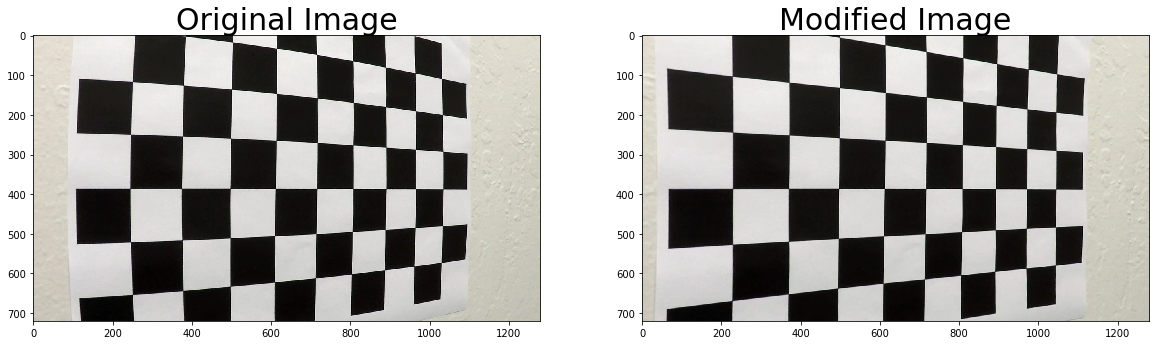

In [5]:
# Test it

files = glob.glob("camera_cal/calibration5.jpg")
for file_name in files:
    img = mpimg.imread(file_name)
    modified = cv2.undistort(img, mtx, dist, None, mtx)
    plot_two_images(img, modified)

# Use color transforms, gradients, etc., to create a thresholded binary image.

In [37]:
class ExtendedLaneProcessor(object):
    yellow = np.uint8([[[255,255,0]]])
    hsv_yellow = cv2.cvtColor(yellow, cv2.COLOR_RGB2HSV)
    # rough color bounds
    lower_white = np.array([0,0,180])
    upper_white = np.array([255,25,255])
    lower_yellow = np.array([15,0,70]) 
    upper_yellow = np.array([45,255,255])
    
    def __init__(self, n):
        self.current_image_idx = 0
        self.master_binary_image = None
        self.history_count = n
        self.history_images = []

    def process_next_image(self, rgb_img, plot_it=False):
        self.window_centroids = None
        self.rgb = rgb_img
        self.hls = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HLS)
        self.hsv = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
        self.shape = rgb_img.shape
        self.green_to_the_right = False
        
        
        processed_image = self.process_image(plot_it)
        
        self.update_history(self.master_binary_image)
        
        return processed_image
        
    def update_history(self, binary_img):
        # oldest one is with lowest index
        if len(self.history_images) < self.history_count:
            self.history_images.append(binary_img)
        else:
            self.history_images = self.history_images[1:]
            self.history_images.append(binary_img)
            
        
        
        
    def grayscale(self, img):
        """Applies the Grayscale transform
        This will return an image with only one color channel
        but NOTE: to see the returned image as grayscale
        (assuming your grayscaled image is called 'gray')
        you should call plt.imshow(gray, cmap='gray')"""
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Or use BGR2GRAY if you read an image with cv2.imread()
        # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
    def region_of_interest(self, img, vertices):
        """
        Applies an image mask.

        Only keeps the region of the image defined by the polygon
        formed from `vertices`. The rest of the image is set to black.
        `vertices` should be a numpy array of integer points.
        """
        #defining a blank mask to start with
        mask = np.zeros_like(img)   

        #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
        if len(img.shape) > 2:
            channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255

        #filling pixels inside the polygon defined by "vertices" with the fill color    
        cv2.fillPoly(mask, vertices, ignore_mask_color)

        #returning the image only where mask pixels are nonzero
        masked_image = cv2.bitwise_and(img, mask)
        return masked_image

    def extract_yellow_and_white(self, img):
        # first convert to HSV color space as it seems to be easier to extract colors in this space

        whiteMask = cv2.inRange(self.hsv, self.lower_white, self.upper_white)
        yellowMask = cv2.inRange(self.hsv, self.lower_yellow, self.upper_yellow)
        white_or_yellow_mask = cv2.bitwise_or(whiteMask, yellowMask)

        yellow_white_extracted = cv2.bitwise_and(img, img, mask=white_or_yellow_mask)
        return yellow_white_extracted
    
    # Region Masking: dismiss useless regions
    def mask_region(self, input_image):
        imshape = np.shape(input_image)
        vertices = np.array([[(0, imshape[0]), (int(450/960 * imshape[1]), int(325/540 * imshape[0])), 
                              (int(500/960 * imshape[1]), int(325/540 * imshape[0])), (imshape[1], imshape[0])]])

        return self.region_of_interest(input_image, vertices)
    
    def compute_perspective_transform(self, img, src, dest):
        return cv2.getPerspectiveTransform(src, dest)
    
    def warp_perspective(self, img, M):
        return cv2.warpPerspective(img, M, img.shape[::-1], flags = cv2.INTER_LINEAR)
    
    def apply_perspective_transform(self, img, inverse = False):
        #          todo somehow choose src points automatically
        #         bottom_y = img.shape[0]
        #         almost_bottom_y = bottom_y - 100
        img_size = (img.shape[1], img.shape[0])
        # Apply a birds-eye view's perspective transform
        src = np.float32(
             [[230, 685],
             [586, 455],
             [695, 455],
             [1043, 685]])
        dst = np.float32(
             [[(img_size[0] / 4), img_size[1]],
             [(img_size[0] / 4), 0],
             [(img_size[0] * 3 / 4), 0],
             [(img_size[0] * 3 / 4), img_size[1]]])
        
        M = cv2.getPerspectiveTransform(src, dst)
        if not inverse:
            warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags = cv2.INTER_LINEAR)
        else:
            M = cv2.getPerspectiveTransform(dst, src)
            warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags = cv2.INTER_LINEAR)
        
        return warped
    
    def threshold_one_channel(self, channel, thresh, plot_it=False):
        binary = np.zeros_like(channel)
        binary[(channel > thresh[0]) & (channel <= thresh[1])] = 1
        if plot_it:
            plot_two_images(channel, binary)
        return binary.astype(np.uint8)
    
    def get_channel(self, rgb_img, channel_name):
        if channel_name == 's':
            return self.hls[:,:,2]
        if channel_name == 'r':
            return self.rgb[:,:,0]
        if channel_name == 'g':
            return self.rgb[:,:,1]
        if channel_name == 'b':
            return self.rgb[:,:,2]
        else:
            print('return None')
            return None
        

    def find_activated_pixels(self, binary_image, window_centroids, window_width = 50, window_height = 80, margin = 100):
        nonzero = binary_image.nonzero()
        nonzeroy = nonzero[0]
        nonzerox = nonzero[1]
        
        left_active_inds = []
        right_active_inds = []
        
        for level in range(0,len(window_centroids)):
            window_centroid_left = window_centroids[level][0]
            window_centroid_right = window_centroids[level][1]
            
            win_xleft_low = window_centroid_left - margin
            win_xleft_high = window_centroid_left + margin
            win_xright_low = window_centroid_right - margin
            win_xright_high = window_centroid_right + margin
            
            win_y_low = binary_image.shape[0] - (level + 1) * window_height
            win_y_high = binary_image.shape[0] - (level) * window_height
            
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            
            left_active_inds.append(good_left_inds)
            right_active_inds.append(good_right_inds)
        
        
        left_lane_inds = np.concatenate(left_active_inds)
        right_lane_inds = np.concatenate(right_active_inds)

        return nonzerox[left_lane_inds], nonzeroy[left_lane_inds], nonzerox[right_lane_inds], nonzeroy[right_lane_inds]

    def draw_window_centroids(self, warped, window_width = 50, window_height = 70, margin = 100, plot_it=False):
        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(self.window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,self.window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,self.window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
        if plot_it:
            plot_two_images(warped, output, title1='warped', title2='windows')
        
    def fit_curve(self, y, x):
        
        if np.amax(y) - np.amin(y) < 200:
            # fit line
            fit = np.polyfit(y, x, 1)
        else:
            fit = np.polyfit(y, x, 2)
            
        return fit
        
    def fit_polynomial(self, warped, plot_it=False):
        if not self.window_centroids:
            self.window_centroids = self.find_window_centroids(warped)
            
        out_img = np.dstack((warped, warped, warped))
        
        if self.window_centroids == None:
            left_fit = self.last_polynomials[0]
            right_fit = self.last_polynomials[1]
        else:
            leftx, lefty, rightx, righty = self.find_activated_pixels(warped, self.window_centroids)
            
            
            left_fit = self.fit_curve(lefty, leftx)
            right_fit = self.fit_curve(righty, rightx)
            
            
            # Maybe here some averaging with last polynomial? Or if its too far away, then we rather use the last?
            # But how do we know the last was correct?
            
            self.last_polynomials = left_fit, right_fit
            
                    ## Visualization ##
            # Colors in the left and right lane regions

            out_img[lefty, leftx] = [255, 0, 0]
            out_img[righty, rightx] = [0, 0, 255]

        if plot_it:    
            self.draw_window_centroids(warped, 50, 80, 100)
        

        
        # Generate x and y values for plotting
        ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
        
        left_fitx = np.polyval(left_fit, ploty)
        right_fitx = np.polyval(right_fit, ploty)
        
        x = np.linspace(0, warped.shape[1] - 1, warped.shape[1])
        y = np.linspace(0, warped.shape[0] - 1, warped.shape[0])
        
        
        def check_inner(y, x):
            return np.logical_and(np.logical_and((np.polyval(left_fit, y) <= x), 
                                                 np.logical_or((np.polyval(right_fit, y) >= x), self.green_to_the_right)), y >= warped.shape[0] / 2)
        
        
        inner_region = np.fromfunction(check_inner, warped.shape, dtype=int).astype(int)
        
        greenx, greeny = np.nonzero(inner_region)
        
        out_img[greenx, greeny] = [0,255,0]
        if plot_it:
            plot_two_images(warped, out_img, title1='warped', title2='green colored')
            
            # Plots the left and right polynomials on the lane lines
            #plt.plot(left_fitx, ploty, color='yellow')
            #plt.plot(right_fitx, ploty, color='yellow')
        
        return out_img
    
    def measure_curvature_real(self, warped):
        '''
        Calculates the curvature of polynomial functions in meters.
        '''
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        
        if not self.window_centroids:
            self.window_centroids = self.find_window_centroids(warped)
        if self.window_centroids == None:
            return self.last_curverads
            
        leftx, lefty, rightx, righty = self.find_activated_pixels(warped, self.window_centroids)
        
        left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty * ym_per_pix, rightx*xm_per_pix, 2)

        # Define y-value where we want radius of curvature
        # We'll choose the maximum y-value, corresponding to the bottom of the image
        y_eval = warped.shape[0] - 100
        y_eval = y_eval * ym_per_pix
        A_left = left_fit_cr[0]
        B_left = left_fit_cr[1]
        A_right = right_fit_cr[0]
        B_right = right_fit_cr[1]
        left_curverad = (np.sqrt((1 + (2 * A_left * y_eval + B_left)**2)**3))/ (np.absolute(2*A_left))  ## Implement the calculation of the left line here
        right_curverad = (np.sqrt((1 + (2 * A_right * y_eval + B_right)**2)**3))/ (np.absolute(2*A_right)) 
        
        self.last_curverads = left_curverad, right_curverad
        return left_curverad, right_curverad
    
    def get_distance_from_center(self, warped):
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        
        if not self.window_centroids:
            self.window_centroids = self.find_window_centroids(warped)
            
        if self.window_centroids == None:
            return self.last_dist_from_center
            
        leftx, lefty, rightx, righty = self.find_activated_pixels(warped, self.window_centroids)
        
        left_fit_cr = np.polyfit(lefty, leftx, 2)
        right_fit_cr = np.polyfit(righty, rightx, 2)
        
        y_eval = warped.shape[0] - 1
        center = (np.polyval(right_fit_cr, y_eval) + np.polyval(left_fit_cr, y_eval)) / 2
        center = center * xm_per_pix
        
        actual_center = (warped.shape[1] / 2) * xm_per_pix
        
        self.last_dist_from_center = center - actual_center
        return center - actual_center
    
    def add_information(self, combined, warped):
        font                   = cv2.FONT_HERSHEY_SIMPLEX
        bottomLeftCornerOfText = (int(combined.shape[1] * 1/8), int(combined.shape[0] / 8))
        lowerLeft = (int(combined.shape[1] * 1/8), int(combined.shape[0] / 8 * 1.5))
        fontScale              = 1
        fontColor              = (255,255,255)
        lineType               = 2
        
        # Some information
        curvature = self.measure_curvature_real(warped)
        approx_curvature = (curvature[0] + curvature[1]) / 2
        distance = self.get_distance_from_center(warped)

        cv2.putText(combined,'approximate curvature: ' + str(approx_curvature), 
            bottomLeftCornerOfText, 
            font, 
            fontScale,
            fontColor,
            lineType)

        cv2.putText(combined,'Distance from center: ' + str(distance) +'m', 
            lowerLeft, 
            font, 
            fontScale,
            fontColor,
            lineType)
        return combined
    
    def aggregate_images(self, binary_img, binary_img_list):
        aggregate = binary_img
        
        for binary_img in binary_img_list:
            aggregate = np.logical_or(aggregate, binary_img)
            
        return aggregate
        
        
    def process_image(self, plot_it=False):
        yellow_white = self.extract_yellow_and_white(self.rgb)
        if plot_it:
            plot_two_images(self.rgb, yellow_white, title1='Original', title2='Yellow White')
        s_channel = self.get_channel(yellow_white,'s')
        r_channel = self.get_channel(yellow_white,'r')
        g_channel = self.get_channel(yellow_white,'g')
        b_channel = self.get_channel(yellow_white, 'b')
        high_r = self.threshold_one_channel(r_channel, (150, 255))
        high_g = self.threshold_one_channel(g_channel, (150, 255))
        high_b = self.threshold_one_channel(b_channel, (200,255))

        high_yellow = np.logical_and(high_r, high_g)
        high_white = np.logical_and(np.logical_and(high_r, high_g), high_b)

        s_high = self.threshold_one_channel(s_channel, (120, 255))

        master = self.mask_region(np.logical_or(high_white, np.logical_and(high_yellow, s_high)).astype(np.uint8))     
        self.master_binary_image = master
        #TODO work only in binary format
        # Overlay images from last $n$ frames
        master = self.aggregate_images(self.master_binary_image, self.history_images).astype(np.uint8)
        
        # plot_two_images(self.master_binary_image, master)
        
        if plot_it:
            plot_two_images(self.rgb, master, title1='Original', title2='masked')
        # Apply a perspective transform to rectify binary image ("birds-eye view").
        warped = self.apply_perspective_transform(master)
        if plot_it:
            plot_two_images(self.rgb, warped, title1='Original', title2='warped')
        # Detect lane pixels and fit to find the lane boundary.

        self.window_centroids = self.find_window_centroids(warped)
        
        if plot_it:
            self.draw_window_centroids(warped, plot_it = True)
        
        if not (self.window_centroids == None):
            active_leftx, active_lefty, active_rightx, active_righty = self.find_activated_pixels(warped, self.window_centroids)
        
            self.draw_window_centroids(warped)
        out_img = self.fit_polynomial(warped, plot_it)


        warped_back = self.apply_perspective_transform(out_img, True)

        combined = cv2.addWeighted(self.rgb, 1, warped_back, 0.6, 0)


        combined = self.add_information(combined, warped)

        return combined
    
    def find_window_centroids(self, image, window_width = 50, window_height = 80, margin = 100, tol = 70):
    
        # window_width = 50 
        # window_height = 80 # Break image into 9 vertical layers since image height is 720
        # margin = 100 # How much to slide left and right for searching

        window_centroids = [] # Store the (left,right) window centroid positions per level
        window = np.ones(window_width) # Create our window template that we will use for convolutions

        # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
        # and then np.convolve the vertical image slice with the window template 

        # Sum quarter bottom of image to get slice, could use a different ratio
        l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
        l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
        r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
        r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
        
        # try lower half:
        
        if (np.amax(np.convolve(window, l_sum))) == 0:
            l_sum = np.sum(image[int(image.shape[0]/2):,:int(image.shape[1]/2)], axis=0)
            l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
            if np.amax(np.convolve(window,l_sum)) == 0:
                print('Where is the fucking left line??')
                return None

                
        if (np.amax(np.convolve(window, r_sum))) == 0:
            r_sum = np.sum(image[int(image.shape[0]/2):,int(image.shape[1]/2):], axis=0)
            r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
            if np.amax(np.convolve(window,r_sum)) == 0:
                print('Where is the fucking right line??')
                return None
        
        # Add what we found for the first layer
        window_centroids.append((l_center,r_center))

        # Go through each layer looking for max pixel locations
        for level in range(1,(int)(image.shape[0]/window_height)):
            # convolve the window into the vertical slice of the image
            image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
            conv_signal = np.convolve(window, image_layer)
            # Find the best left centroid by using past left center as a reference
            # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
            offset = window_width/2
            l_min_index = int(max(l_center + offset - margin,0))
            l_max_index = int(min(l_center + offset + margin,image.shape[1]))
            l_center_current = np.argmax(conv_signal[l_min_index:l_max_index]) + l_min_index - offset
            # Find the best right centroid by using past right center as a reference
            
            if (np.absolute(l_center_current - l_center) > tol):
                # idea: use last diff for this diff... to keep the curvature
                if len(window_centroids) >= 2:
                    before_last_left = window_centroids[-2][0]
                    diff = l_center - before_last_left
                    l_center_current = l_center + diff
                else:
                    l_center_current = l_center
            
            
            r_min_index = int(max(r_center+offset-margin,0))
            r_max_index = int(min(r_center+offset+margin,image.shape[1]))
            if len(conv_signal[r_min_index:r_max_index]) == 0:
                r_center_current = image.shape[1]
                self.green_to_the_right = True
            else: 
                r_center_current = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
            
            if (np.absolute(r_center_current - r_center) > tol):
                # idea: use last diff for this diff... to keep the curvature
                if len(window_centroids) >= 2:
                    before_last_right = window_centroids[-2][1]
                    diff = r_center - before_last_right
                    r_center_current = r_center + diff
                else:
                    r_center_current = r_center
            
            l_center = l_center_current
            r_center = r_center_current
            # Add what we found for that layer
            window_centroids.append((l_center_current,r_center_current))

        return window_centroids

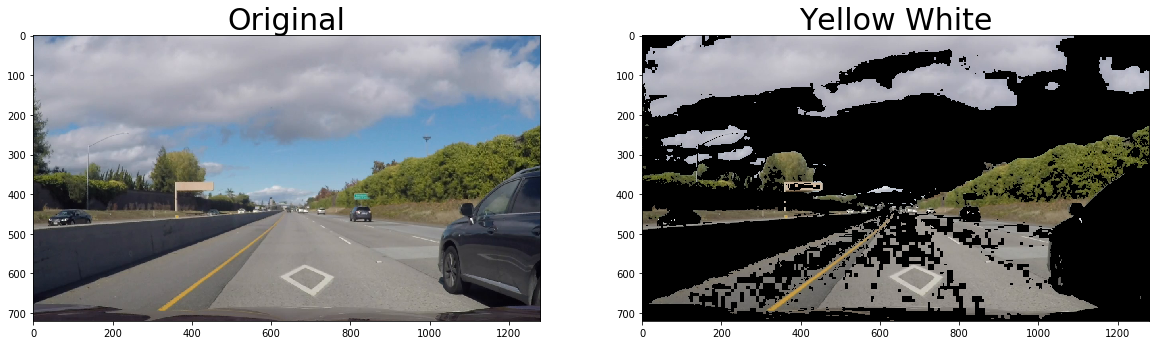

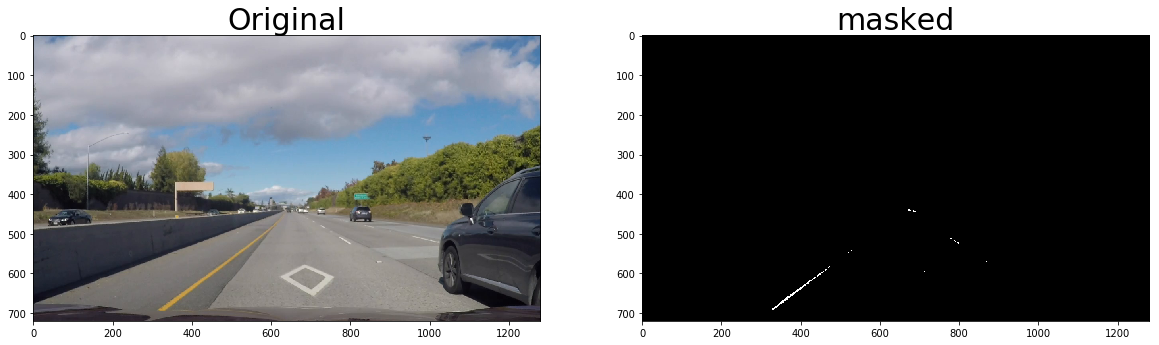

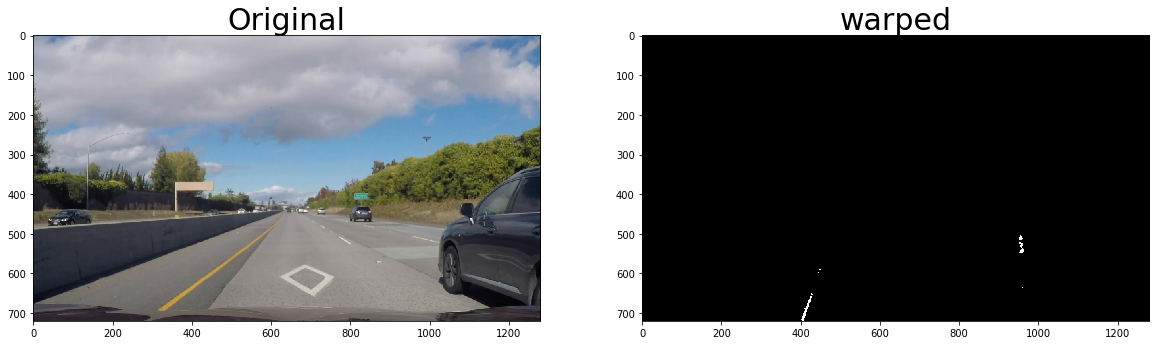

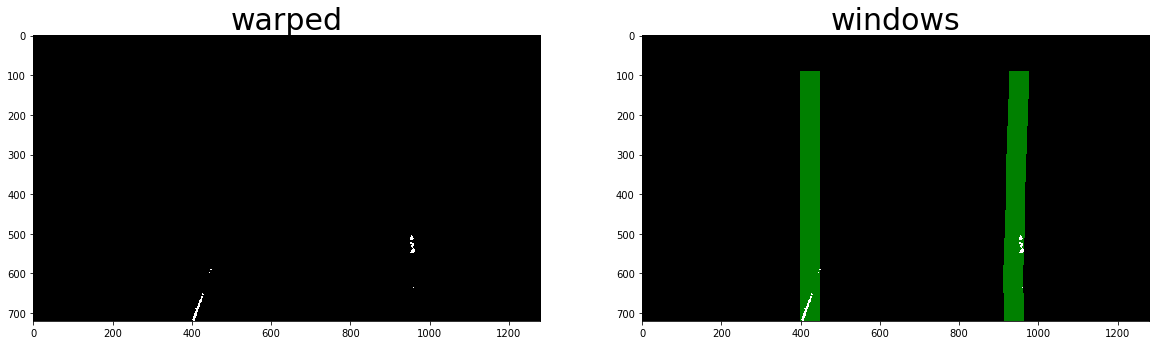

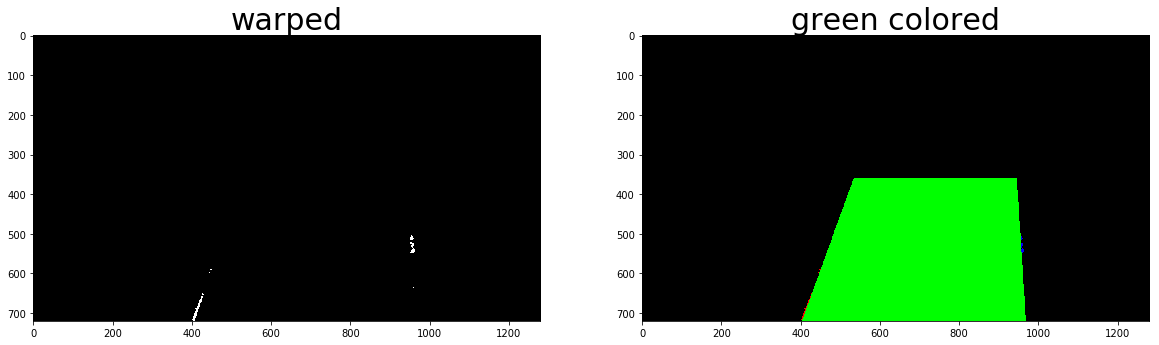

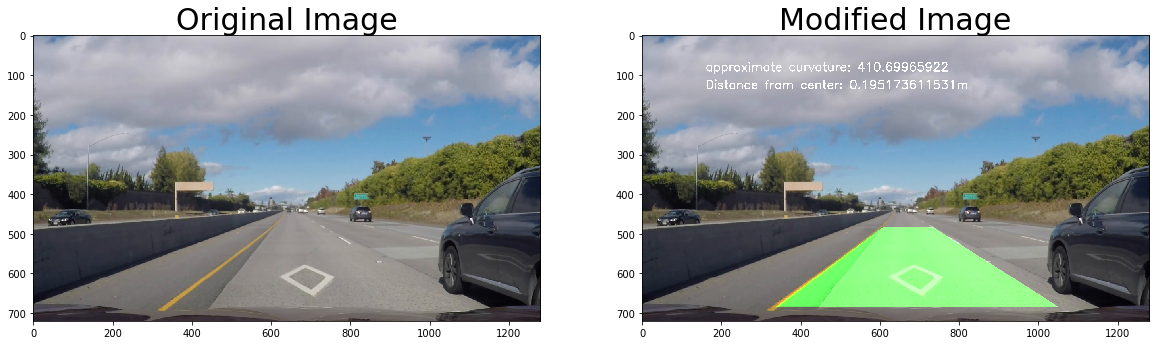

In [41]:
from PIL import Image

file = 'test_images_output/15.png'
image = np.asarray(Image.open(file))

lp = ExtendedLaneProcessor(2)

combined = lp.process_next_image(image, True)
plot_two_images(image, combined)

In [8]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def helper(img):
    return ExtendedLaneProcessor(img).process_image()

In [ ]:
video_output = 'video_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")

# t=1046
# imgpath = os.path.join('test_images_output/', '{}.png'.format(t))
# clip.save_frame(imgpath, t) 
lp = ExtendedLaneProcessor(2)
white_clip = clip1.fl_image(lp.process_next_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video video_output/project_video.mp4
[MoviePy] Writing video video_output/project_video.mp4





  0%|          | 0/1261 [00:00<?, ?it/s]


  0%|          | 1/1261 [00:00<07:06,  2.95it/s]


  0%|          | 2/1261 [00:00<07:19,  2.86it/s]


  0%|          | 3/1261 [00:01<07:19,  2.87it/s]


  0%|          | 4/1261 [00:01<07:05,  2.96it/s]


  0%|          | 5/1261 [00:01<06:55,  3.02it/s]


  0%|          | 6/1261 [00:01<06:52,  3.04it/s]


  1%|          | 7/1261 [00:02<06:52,  3.04it/s]


  1%|          | 8/1261 [00:02<06:54,  3.03it/s]


  1%|          | 9/1261 [00:02<06:50,  3.05it/s]


  1%|          | 10/1261 [00:03<06:50,  3.05it/s]


  1%|          | 11/1261 [00:03<06:48,  3.06it/s]


  1%|          | 12/1261 [00:03<06:49,  3.05it/s]


  1%|          | 13/1261 [00:04<06:49,  3.04it/s]


  1%|          | 14/1261 [00:04<06:49,  3.05it/s]


  1%|          | 15/1261 [00:04<06:50,  3.04it/s]


  1%|▏         | 16/1261 [00:05<06:50,  3.03it/s]


  1%|▏         | 17/1261 [00:05<06:50,  3.03it/s]


  1%|▏         | 18/1261 [00:05<06:50,  3.03it/s]


  2%|▏         | 19/1261 [0

 11%|█         | 134/1261 [00:46<06:32,  2.87it/s]


 11%|█         | 135/1261 [00:46<06:31,  2.87it/s]


 11%|█         | 136/1261 [00:47<06:31,  2.88it/s]


 11%|█         | 137/1261 [00:47<06:30,  2.88it/s]


 11%|█         | 138/1261 [00:47<06:30,  2.88it/s]


 11%|█         | 139/1261 [00:48<06:29,  2.88it/s]


 11%|█         | 140/1261 [00:48<06:29,  2.88it/s]


 11%|█         | 141/1261 [00:48<06:28,  2.88it/s]


 11%|█▏        | 142/1261 [00:49<06:28,  2.88it/s]


 11%|█▏        | 143/1261 [00:49<06:28,  2.88it/s]


 11%|█▏        | 144/1261 [00:49<06:27,  2.88it/s]


 11%|█▏        | 145/1261 [00:50<06:27,  2.88it/s]


 12%|█▏        | 146/1261 [00:50<06:26,  2.88it/s]


 12%|█▏        | 147/1261 [00:50<06:26,  2.89it/s]


 12%|█▏        | 148/1261 [00:51<06:25,  2.89it/s]


 12%|█▏        | 149/1261 [00:51<06:25,  2.89it/s]


 12%|█▏        | 150/1261 [00:51<06:24,  2.89it/s]


 12%|█▏        | 151/1261 [00:52<06:24,  2.89it/s]


 12%|█▏        | 152/1261 [00:52<06:23,  2.89i

 21%|██        | 266/1261 [01:32<05:47,  2.86it/s]


 21%|██        | 267/1261 [01:33<05:47,  2.86it/s]


 21%|██▏       | 268/1261 [01:33<05:47,  2.86it/s]


 21%|██▏       | 269/1261 [01:34<05:46,  2.86it/s]


 21%|██▏       | 270/1261 [01:34<05:46,  2.86it/s]


 21%|██▏       | 271/1261 [01:34<05:46,  2.86it/s]


 22%|██▏       | 272/1261 [01:35<05:45,  2.86it/s]


 22%|██▏       | 273/1261 [01:35<05:45,  2.86it/s]


 22%|██▏       | 274/1261 [01:35<05:45,  2.86it/s]


 22%|██▏       | 275/1261 [01:36<05:45,  2.86it/s]


 22%|██▏       | 276/1261 [01:36<05:44,  2.86it/s]


 22%|██▏       | 277/1261 [01:36<05:44,  2.86it/s]


 22%|██▏       | 278/1261 [01:37<05:44,  2.86it/s]


 22%|██▏       | 279/1261 [01:37<05:43,  2.86it/s]


 22%|██▏       | 280/1261 [01:38<05:43,  2.86it/s]


 22%|██▏       | 281/1261 [01:38<05:43,  2.86it/s]


 22%|██▏       | 282/1261 [01:38<05:42,  2.86it/s]


 22%|██▏       | 283/1261 [01:39<05:42,  2.86it/s]


 23%|██▎       | 284/1261 [01:39<05:41,  2.86i

 32%|███▏      | 398/1261 [02:20<05:04,  2.84it/s]


 32%|███▏      | 399/1261 [02:20<05:03,  2.84it/s]


 32%|███▏      | 400/1261 [02:20<05:03,  2.84it/s]


 32%|███▏      | 401/1261 [02:21<05:03,  2.84it/s]


 32%|███▏      | 402/1261 [02:21<05:02,  2.84it/s]


 32%|███▏      | 403/1261 [02:21<05:02,  2.84it/s]


 32%|███▏      | 404/1261 [02:22<05:01,  2.84it/s]


 32%|███▏      | 405/1261 [02:22<05:01,  2.84it/s]


 32%|███▏      | 406/1261 [02:23<05:01,  2.84it/s]


 32%|███▏      | 407/1261 [02:23<05:00,  2.84it/s]


 32%|███▏      | 408/1261 [02:23<05:00,  2.84it/s]


 32%|███▏      | 409/1261 [02:24<04:59,  2.84it/s]


 33%|███▎      | 410/1261 [02:24<04:59,  2.84it/s]


 33%|███▎      | 411/1261 [02:24<04:59,  2.84it/s]


 33%|███▎      | 412/1261 [02:25<04:58,  2.84it/s]


 33%|███▎      | 413/1261 [02:25<04:58,  2.84it/s]


 33%|███▎      | 414/1261 [02:25<04:58,  2.84it/s]


 33%|███▎      | 415/1261 [02:26<04:57,  2.84it/s]


 33%|███▎      | 416/1261 [02:26<04:57,  2.84i

 42%|████▏     | 530/1261 [03:09<04:20,  2.80it/s]


 42%|████▏     | 531/1261 [03:09<04:20,  2.80it/s]


 42%|████▏     | 532/1261 [03:09<04:20,  2.80it/s]


 42%|████▏     | 533/1261 [03:10<04:19,  2.80it/s]


 42%|████▏     | 534/1261 [03:10<04:19,  2.80it/s]


 42%|████▏     | 535/1261 [03:10<04:19,  2.80it/s]


 43%|████▎     | 536/1261 [03:11<04:18,  2.80it/s]


 43%|████▎     | 537/1261 [03:11<04:18,  2.80it/s]


 43%|████▎     | 538/1261 [03:11<04:18,  2.80it/s]


 43%|████▎     | 539/1261 [03:12<04:17,  2.80it/s]


 43%|████▎     | 540/1261 [03:12<04:17,  2.80it/s]


 43%|████▎     | 541/1261 [03:13<04:16,  2.80it/s]


 43%|████▎     | 542/1261 [03:13<04:16,  2.80it/s]


 43%|████▎     | 543/1261 [03:13<04:16,  2.80it/s]


 43%|████▎     | 544/1261 [03:14<04:15,  2.80it/s]


 43%|████▎     | 545/1261 [03:14<04:15,  2.80it/s]


 43%|████▎     | 546/1261 [03:14<04:15,  2.80it/s]


 43%|████▎     | 547/1261 [03:15<04:14,  2.80it/s]


 43%|████▎     | 548/1261 [03:15<04:14,  2.80i

In [42]:
video_output2 = 'video_output/challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip2 = VideoFileClip("challenge_video.mp4")
lp = ExtendedLaneProcessor(2)
# t=1
# imgpath = os.path.join('test_images_output/', '{}.png'.format(t))
# clip2.save_frame(imgpath, t) 

challenge_clip = clip2.fl_image(lp.process_next_image) #NOTE: this function expects color images!!
%time challenge_clip.write_videofile(video_output2, audio=False)

[MoviePy] >>>> Building video video_output/challenge_video.mp4
[MoviePy] Writing video video_output/challenge_video.mp4





  0%|          | 0/485 [00:00<?, ?it/s]


  0%|          | 1/485 [00:00<02:05,  3.85it/s]


  0%|          | 2/485 [00:00<02:08,  3.76it/s]


  1%|          | 3/485 [00:00<02:11,  3.67it/s]


  1%|          | 4/485 [00:01<02:14,  3.59it/s]


  1%|          | 5/485 [00:01<02:15,  3.55it/s]


  1%|          | 6/485 [00:01<02:14,  3.56it/s]


  1%|▏         | 7/485 [00:01<02:14,  3.57it/s]


  2%|▏         | 8/485 [00:02<02:14,  3.56it/s]


  2%|▏         | 9/485 [00:02<02:09,  3.68it/s]

Where is the fucking right line??
Where is the fucking right line??
Where is the fucking right line??
Where is the fucking right line??





  2%|▏         | 10/485 [00:02<02:08,  3.71it/s]


  2%|▏         | 11/485 [00:02<02:09,  3.67it/s]


  2%|▏         | 12/485 [00:03<02:08,  3.68it/s]


  3%|▎         | 13/485 [00:03<02:08,  3.68it/s]


  3%|▎         | 14/485 [00:03<02:07,  3.70it/s]


  3%|▎         | 15/485 [00:04<02:06,  3.70it/s]


  3%|▎         | 16/485 [00:04<02:06,  3.70it/s]


  4%|▎         | 17/485 [00:04<02:06,  3.70it/s]


  4%|▎         | 18/485 [00:04<02:06,  3.69it/s]


  4%|▍         | 19/485 [00:05<02:06,  3.69it/s]


  4%|▍         | 20/485 [00:05<02:06,  3.69it/s]


  4%|▍         | 21/485 [00:05<02:05,  3.69it/s]


  5%|▍         | 22/485 [00:05<02:05,  3.68it/s]


  5%|▍         | 23/485 [00:06<02:05,  3.68it/s]


  5%|▍         | 24/485 [00:06<02:05,  3.67it/s]


  5%|▌         | 25/485 [00:06<02:05,  3.67it/s]


  5%|▌         | 26/485 [00:07<02:05,  3.67it/s]


  6%|▌         | 27/485 [00:07<02:04,  3.67it/s]


  6%|▌         | 28/485 [00:07<02:04,  3.66it/s]


  6%|▌         | 29/485 [00:

Where is the fucking left line??
Where is the fucking left line??
Where is the fucking left line??
Where is the fucking left line??





 14%|█▍        | 69/485 [00:19<01:55,  3.60it/s]


 14%|█▍        | 70/485 [00:19<01:55,  3.59it/s]


 15%|█▍        | 71/485 [00:19<01:55,  3.59it/s]


 15%|█▍        | 72/485 [00:20<01:55,  3.59it/s]


 15%|█▌        | 73/485 [00:20<01:54,  3.58it/s]


 15%|█▌        | 74/485 [00:20<01:54,  3.58it/s]


 15%|█▌        | 75/485 [00:20<01:54,  3.58it/s]


 16%|█▌        | 76/485 [00:21<01:54,  3.58it/s]


 16%|█▌        | 77/485 [00:21<01:54,  3.58it/s]


 16%|█▌        | 78/485 [00:21<01:53,  3.58it/s]


 16%|█▋        | 79/485 [00:22<01:53,  3.57it/s]


 16%|█▋        | 80/485 [00:22<01:53,  3.57it/s]


 17%|█▋        | 81/485 [00:22<01:53,  3.57it/s]


 17%|█▋        | 82/485 [00:22<01:52,  3.57it/s]


 17%|█▋        | 83/485 [00:23<01:52,  3.57it/s]


 17%|█▋        | 84/485 [00:23<01:52,  3.57it/s]


 18%|█▊        | 85/485 [00:23<01:52,  3.56it/s]


 18%|█▊        | 86/485 [00:24<01:51,  3.58it/s]

Where is the fucking left line??
Where is the fucking left line??
Where is the fucking left line??
Where is the fucking left line??





 18%|█▊        | 87/485 [00:24<01:50,  3.59it/s]

Where is the fucking left line??
Where is the fucking left line??
Where is the fucking left line??
Where is the fucking left line??





 18%|█▊        | 88/485 [00:24<01:50,  3.59it/s]


 18%|█▊        | 89/485 [00:24<01:50,  3.59it/s]


 19%|█▊        | 90/485 [00:25<01:49,  3.59it/s]


 19%|█▉        | 91/485 [00:25<01:49,  3.59it/s]


 19%|█▉        | 92/485 [00:25<01:49,  3.59it/s]


 19%|█▉        | 93/485 [00:25<01:49,  3.59it/s]


 19%|█▉        | 94/485 [00:26<01:49,  3.59it/s]


 20%|█▉        | 95/485 [00:26<01:48,  3.58it/s]


 20%|█▉        | 96/485 [00:26<01:48,  3.58it/s]


 20%|██        | 97/485 [00:27<01:48,  3.58it/s]


 20%|██        | 98/485 [00:27<01:48,  3.58it/s]


 20%|██        | 99/485 [00:27<01:47,  3.57it/s]


 21%|██        | 100/485 [00:27<01:47,  3.57it/s]


 21%|██        | 101/485 [00:28<01:47,  3.57it/s]


 21%|██        | 102/485 [00:28<01:47,  3.58it/s]


 21%|██        | 103/485 [00:28<01:46,  3.58it/s]


 21%|██▏       | 104/485 [00:29<01:46,  3.58it/s]


 22%|██▏       | 105/485 [00:29<01:46,  3.57it/s]


 22%|██▏       | 106/485 [00:29<01:46,  3.57it/s]


 22%|██▏       | 107/

Where is the fucking left line??
Where is the fucking left line??
Where is the fucking left line??
Where is the fucking left line??
Where is the fucking left line??
Where is the fucking left line??





 28%|██▊       | 135/485 [00:37<01:37,  3.57it/s]


 28%|██▊       | 136/485 [00:37<01:37,  3.58it/s]

Where is the fucking left line??
Where is the fucking left line??
Where is the fucking left line??
Where is the fucking left line??
Where is the fucking left line??
Where is the fucking left line??





 28%|██▊       | 137/485 [00:38<01:36,  3.59it/s]

Where is the fucking left line??
Where is the fucking left line??
Where is the fucking left line??
Where is the fucking left line??
Where is the fucking left line??
Where is the fucking left line??





 28%|██▊       | 138/485 [00:38<01:36,  3.60it/s]


 29%|██▊       | 139/485 [00:38<01:35,  3.61it/s]

Where is the fucking left line??
Where is the fucking left line??
Where is the fucking left line??
Where is the fucking left line??
Where is the fucking left line??
Where is the fucking left line??





 29%|██▉       | 140/485 [00:38<01:35,  3.62it/s]

Where is the fucking left line??
Where is the fucking left line??
Where is the fucking left line??
Where is the fucking left line??
Where is the fucking left line??
Where is the fucking left line??





 29%|██▉       | 141/485 [00:38<01:34,  3.63it/s]


 29%|██▉       | 142/485 [00:38<01:34,  3.64it/s]

Where is the fucking left line??
Where is the fucking left line??
Where is the fucking left line??
Where is the fucking left line??
Where is the fucking left line??
Where is the fucking left line??





 29%|██▉       | 143/485 [00:39<01:33,  3.65it/s]

Where is the fucking left line??
Where is the fucking left line??
Where is the fucking left line??
Where is the fucking left line??
Where is the fucking left line??
Where is the fucking left line??





 30%|██▉       | 144/485 [00:39<01:33,  3.67it/s]


 30%|██▉       | 145/485 [00:39<01:32,  3.68it/s]

Where is the fucking left line??
Where is the fucking left line??
Where is the fucking left line??
Where is the fucking left line??
Where is the fucking left line??
Where is the fucking left line??





 30%|███       | 146/485 [00:39<01:31,  3.69it/s]

Where is the fucking left line??
Where is the fucking left line??
Where is the fucking left line??
Where is the fucking left line??
Where is the fucking left line??
Where is the fucking left line??





 30%|███       | 147/485 [00:39<01:31,  3.70it/s]

Where is the fucking left line??
Where is the fucking left line??





 31%|███       | 148/485 [00:40<01:31,  3.69it/s]


 31%|███       | 149/485 [00:40<01:31,  3.69it/s]


 31%|███       | 150/485 [00:40<01:30,  3.68it/s]


 31%|███       | 151/485 [00:41<01:30,  3.68it/s]


 31%|███▏      | 152/485 [00:41<01:30,  3.67it/s]


 32%|███▏      | 153/485 [00:41<01:30,  3.67it/s]


 32%|███▏      | 154/485 [00:42<01:30,  3.66it/s]


 32%|███▏      | 155/485 [00:42<01:30,  3.66it/s]


 32%|███▏      | 156/485 [00:42<01:30,  3.66it/s]


 32%|███▏      | 157/485 [00:42<01:29,  3.65it/s]


 33%|███▎      | 158/485 [00:43<01:29,  3.65it/s]


 33%|███▎      | 159/485 [00:43<01:29,  3.64it/s]


 33%|███▎      | 160/485 [00:43<01:29,  3.64it/s]


 33%|███▎      | 161/485 [00:44<01:29,  3.63it/s]


 33%|███▎      | 162/485 [00:44<01:28,  3.63it/s]


 34%|███▎      | 163/485 [00:44<01:28,  3.63it/s]


 34%|███▍      | 164/485 [00:45<01:28,  3.62it/s]


 34%|███▍      | 165/485 [00:45<01:28,  3.62it/s]


 34%|███▍      | 166/485 [00:45<01:28,  3.62it/s]


 34%|███▍

 58%|█████▊    | 282/485 [01:21<00:58,  3.48it/s]


 58%|█████▊    | 283/485 [01:21<00:58,  3.48it/s]


 59%|█████▊    | 284/485 [01:21<00:57,  3.48it/s]


 59%|█████▉    | 285/485 [01:22<00:57,  3.48it/s]


 59%|█████▉    | 286/485 [01:22<00:57,  3.48it/s]


 59%|█████▉    | 287/485 [01:22<00:56,  3.47it/s]


 59%|█████▉    | 288/485 [01:22<00:56,  3.47it/s]


 60%|█████▉    | 289/485 [01:23<00:56,  3.47it/s]


 60%|█████▉    | 290/485 [01:23<00:56,  3.47it/s]


 60%|██████    | 291/485 [01:23<00:55,  3.47it/s]


 60%|██████    | 292/485 [01:24<00:55,  3.47it/s]


 60%|██████    | 293/485 [01:24<00:55,  3.47it/s]


 61%|██████    | 294/485 [01:24<00:54,  3.47it/s]


 61%|██████    | 295/485 [01:24<00:54,  3.47it/s]


 61%|██████    | 296/485 [01:25<00:54,  3.47it/s]


 61%|██████    | 297/485 [01:25<00:54,  3.47it/s]


 61%|██████▏   | 298/485 [01:25<00:53,  3.47it/s]


 62%|██████▏   | 299/485 [01:26<00:53,  3.47it/s]


 62%|██████▏   | 300/485 [01:26<00:53,  3.47it/s]


 62%|██████▏

 86%|████████▌ | 416/485 [02:00<00:19,  3.46it/s]


 86%|████████▌ | 417/485 [02:00<00:19,  3.46it/s]


 86%|████████▌ | 418/485 [02:00<00:19,  3.46it/s]


 86%|████████▋ | 419/485 [02:01<00:19,  3.46it/s]


 87%|████████▋ | 420/485 [02:01<00:18,  3.46it/s]


 87%|████████▋ | 421/485 [02:01<00:18,  3.46it/s]


 87%|████████▋ | 422/485 [02:02<00:18,  3.46it/s]


 87%|████████▋ | 423/485 [02:02<00:17,  3.46it/s]


 87%|████████▋ | 424/485 [02:02<00:17,  3.46it/s]


 88%|████████▊ | 425/485 [02:02<00:17,  3.46it/s]


 88%|████████▊ | 426/485 [02:03<00:17,  3.46it/s]


 88%|████████▊ | 427/485 [02:03<00:16,  3.46it/s]


 88%|████████▊ | 428/485 [02:03<00:16,  3.46it/s]


 88%|████████▊ | 429/485 [02:04<00:16,  3.46it/s]


 89%|████████▊ | 430/485 [02:04<00:15,  3.46it/s]


 89%|████████▉ | 431/485 [02:04<00:15,  3.46it/s]


 89%|████████▉ | 432/485 [02:05<00:15,  3.46it/s]


 89%|████████▉ | 433/485 [02:05<00:15,  3.46it/s]


 89%|████████▉ | 434/485 [02:05<00:14,  3.46it/s]


 90%|███████

[MoviePy] Done.
[MoviePy] >>>> Video ready: video_output/challenge_video.mp4 

CPU times: user 8min 49s, sys: 46.3 s, total: 9min 35s
Wall time: 2min 21s


In [100]:

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")
t=2
for i,frame in enumerate(clip1.iter_frames()):
    if i == t:
        exampleFrame2 = frame

In [31]:
video_output3 = 'video_output/harder_challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip3 = VideoFileClip("harder_challenge_video.mp4")
lp = ExtendedLaneProcessor(2)
t=14.5
imgpath = os.path.join('test_images_output/', '{}.png'.format(t))
clip2.save_frame(imgpath, t) 

# harder_challenge_clip = clip3.fl_image(lp.process_next_image) #NOTE: this function expects color images!!
# %time harder_challenge_clip.write_videofile(video_output3, audio=False)